In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import roots_legendre

# Cvičení 11: Numerická integrace (kvadratura)

---
- [poznámky z přednášky - obecné kvadratury](https://www.karlin.mff.cuni.cz/~kucera/ZNM/7%20-%20Kvadratura.pdf)
- [poznámky z přednášky - Gaussova kvadratura](https://www.karlin.mff.cuni.cz/~kucera/ZNM/8%20-%20Gaussovy%20a%20slozene%20kvadraturni%20vzorce.pdf)
- další materiály
  - skripta [Dolejší: Fundamentals of Numerical Mathematics](https://www.karlin.mff.cuni.cz/~dolejsi/Vyuka/ZNM.pdf) (Kapitola 5)
  - skripta [Foundations of Applied Mathematics](https://foundations-of-applied-mathematics.github.io/) (Volume 2, Kapitola 11)

- ***Primární úlohy*** : A1, A2, A3

- ***Úlohy k bonusové části zkoušky*** : A2, ZÚ - symetrie Lagrangeových bazických polynomů

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím odvodit základní kvadraturní pravidla.
  - Umím vyjmenovat výhody a nevýhody kvadratur Newton-Cotes a Gauss-Legendre a zdůvodnit jejich numerické chování.
  - Umím porovnat interpolační a kompozitní kvadratury.
  - Umím transformovat kvadraturu založenou na polynomiální interpolaci definovanou na intervalu $(a,b)$ na interval $(c,d)$.
---

Už jsme se podívali na to, jak aproximovat funkci pomocí polynomu nebo po částech polynomiální funkce. Další přirozený krok je podívat se na to, jak aproximovat integrál funkce, tzv. numerická kvadratura nebo numerická integrace.

## Část A: Metody založené na polynomiální interpolaci

Idea je vcelku přímočará, máme-li polynom $p_f(x)$ aproximující funkci $f(x)$ na intervalu $(a,b) \subset \mathbb{R}$, pak dává smysl očekávat, že

$$
\int_{a}^{b} f(x) \mathrm{d}x \, \approx \, \int_{a}^{b} p_f(x) \mathrm{d}x.
$$

V čem je to dobré? Integrovat polynomy je hračka! Vzpomene si, že umíme $p_f(x)$ najít pomocí interpolace $f$ a tedy se dá napsat jako
$$
    p_f(x) = \sum\limits_{i=0}^{n} f(x_i)\ell_i(x),\qquad \ell_i(x) = \prod_{k=0,k\neq i}^{n} \frac{x-x_k}{x_i-x_k} \;.
$$
a tedy
$$
    \int_a^b f(x)\, \mathrm{d}x \approx \sum_{i=0}^n f(x_i) w_i \;,
$$
kde váhy $w_i$ odpovídají integrálům Lagrangeových polynomů $\ell_i(x)$, tj.
$$
    w_i = \int_{a}^b \ell_i(t)\,\mathrm{d}t.
$$

> Poznámka 1: V případě interpolace jsme používali reformulaci těchto polynomů, tzv. *barycentrickou formulaci*. To bylo numericky nutné, pokud jsme chtěli součet Lagrangeových polynomů vyhodnocovat v nějakých bodech. Nyní je chceme (každý zvlášť) integrovat a tedy barycentrická formulace už není vhodná.

> Poznámka 2: Pro *barycentrickou formulaci* polynomiální interpolace jsme si také zaváděli *váhy* $w_i$ - zjevně to nejsou stejné váhy jako zavádíme pro kvadratury a neměli bychom si je plést.


Na přednášce jsme viděli dva základní "reprezentanty" numerických kvadratur založených na polynomiální interpolaci:

- [Newton-Cotes kvadratury](https://en.wikipedia.org/wiki/Newton%E2%80%93Cotes_formulas) - opovídá volbě ekvidistantních bodů pro interpolant $p_f(x)$.
- [Gaussovy kvadratury](https://en.wikipedia.org/wiki/Gaussian_quadrature) - opovídá volbě bodů pro interpolant $p_f(x)$ jako kořenů ortogonálních polynomů.
  - některé zdroje tedy mluví o "Gauss-Legendre kvadratuře" nebo "Gauss-Chebyshev kvadratuře" (tj. kvadratury, kde body pro interpolant $p_f(x)$ na $[a,b]$ jsou volenz jako kořeny $n$-tého Legendrova/Chebyshevova polynomu an $[a,b]$).
  - pokud řekneme pouze "Gaussova kvadratura", rozumíme tím zpravidla "Gauss-Legendrovu kvadraturu", stejně jako an přednášce.  


### Úloha A1 - kvadraturní váhy

---
**Kódění** :
- Naimplementujte funkci `LagrangePolyKoef()` podle anotace níže.
  - Mně se hodily `numpy` funkce [`np.poly1d()`](https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html), která nám umožní konstruovat polynomy na $\mathbb{R}$ pomocí kořenů.
  - Konstrukcí polynomu na základě kořenů nám [`np.poly1d()`](https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html) vrátí ***monický*** polynom s danými kořeny.

- Naimplementujte funkci `KvadraturVahy()` podle anotace níže.
  - Polynomy lze integrovat vestavěnou funkcí pro [`np.polyint()`](https://numpy.org/doc/stable/reference/generated/numpy.polyint.html#numpy.polyint), která nám vrátí primitivní funkci ka danému polynomu (tj. také polynom).
----

In [ ]:
def LagrangePolyKoef(i, x_interp):
  '''
  Spocitame koeficienty i-teho bazickeho Lagrangeova polynomu "l_i(x)" pro body "x_interp".

  Input
  -------
  i :   np.int32. prirozene cislo mezi 0 a "len(x_interp)"
  x_interp :  np.array dimenze "n+1" s prvky np.float64. Kvadraturni body/uzly - rad kvadratury je alespon rad interpolace, tj. alespon delka tohoto pole.

  Output
  -------
  LagrangeKoef :  np.array dimenze "n+1" s prvky np.float64. Koeficienty "[an,...,a1,a0]" "i"-teho bezickeho lagrangeova polynomu, tj. plati " l_i(x) = sum_{i=0}^{n} a_i * x^i ".

  Poznamka
  -------
  Pokud mame pouze jeden interpolacni bod, pak "aproximujeme funkci konstantou" a dostavame obdelnikove pravidlo (viz prednaska). Vypocet pro tento pripad muze byt snazsi udelat "separatne" pomoci "if-else"
  '''
  return LagrangeKoef


#################################################################### Testovani
def test_LagrangePolyKoef():
    poly10 = LagrangePolyKoef(4, np.linspace(-1, 1, 10))
    assert poly10.shape == (10,), "Lagrangeuv polynom ma spatny stupen"
    assert LagrangePolyKoef(0, [5]) == np.array([1]), "Pokud mame pouze jeden interpolacni bod -> polynom musi byt konstantni a slpnovat 'l_i(x_i)=1'."
    assert np.allclose( LagrangePolyKoef(0, np.array([0, 0.5, 1])), np.array([2, -3, 1]) ), "Spocitan spatny Lagrangeuv polynom"
    assert np.allclose( LagrangePolyKoef(1, np.array([0, 0.5, 1])), np.array([-4, 4, 0]) ), "Spocitan spatny Lagrangeuv polynom"
    assert ( np.abs(np.sum(poly10)) < 1e-14 ), "Pokud mame bod + meyi interp/kvadaraturnimi body (tj. x_i = 1 pro nejake i), pak soucet koeficientu l_j(x) je nula pro vsechny j ruzne od i"
    return '"LagrangePolyKoef()" jsou OK'
test_LagrangePolyKoef()
#################################################################### Testovani

'"LagrangePolyKoef()" jsou OK'

In [ ]:
def KvadraturVahy(a, b, x_interp):
  '''
  Spocteme kvadraturni vahy, ktere jsou dane jako integraly Lagrangeovych polynomu na integracnim intervale [a,b].

  Input
  -------
  a :   np.float64. Levy okraj integracniho intervalu
  b :   np.float64. Pravy okraj integracniho intervalu
  x_interp :  np.array dimenze "n+1" s prvky np.float64. Kvadraturni body/uzly - rad kvadratury je alespon rad interpolace, tj. alespon delka tohoto pole.

  Output
  -------
  w :  np.array dimenze "n+1" s prvky np.float64. Kvadraturni vahy "[w0,...,wn]", tj. plati "w_i = int_a^b l_i(x) dx".
  '''
  return w

#################################################################### Testovani
def test_KvadraturVahy():
    assert np.allclose( KvadraturVahy(0, 1, np.array([0.5])), np.array([1]) ), "Kvadraturni vahy jsou spatne na intervalu (0,1) pro jeden itnerp. bod [0.5] (mid-point kvadratura) - output je {}, ale mel by byt {}".format(KvadraturVahy(0, 1, np.array([0.5])),1)
    assert np.allclose( KvadraturVahy(0, 1, np.array([0., 1.])), np.array([0.5, 0.5]) ), "Kvadraturni vahy jsou spatne na intervalu (0,1) pro itnerp. body [0,1] (lichobeznikove pravidlo) - output je {}, ale mel by byt {}".format(KvadraturVahy(0, 1, np.array([0, 1])), np.array([0.5, 0.5]))
    assert np.allclose( KvadraturVahy(0, 1, np.array([0., 0.5, 1.])), np.array([1 / 6, 2 / 3, 1 / 6]) ), "Kvadraturni vahy jsou spatne na intervalu (0,1) pro itnerp. body [0,0.5,1] (Simpsonovo pravidlo/kvadratura) - output je {}, ale mel by byt {}".format(KvadraturVahy(0, 1, np.array([0, 0.5, 1])), np.array([1 / 6, 2 / 3, 1 / 6]))
    assert np.allclose( KvadraturVahy(-3, 3, np.array([-1., 0., 1.])), np.array([9, -12, 9]) ), "Kvadraturni vahy jsou spatne na intervalu (-3,3) pro itnerp. body [-1,0,1] - output je {}, ale mel by byt {}".format(KvadraturVahy(-3, 3, np.array([-1, 0, 1])), np.array([9, -12, 9]))
    assert np.allclose( KvadraturVahy(-12, 3, np.array([-10. -5., 0., 1.])), np.array([4.52045455, 5.175, 1.725, 3.57954545]), ), "Kvadraturni vahy jsou spatne na intervalu (-12,3) pro itnerp. body [-10,-5,0,1]"

    koreny, vahy = roots_legendre(10)
    assert np.allclose( KvadraturVahy(-1, 1, koreny), vahy ), "Kvadraturni vahy jsou spatne na intervalu (-1,1) pro Legendrovy itnerp. body"
    return '"KvadraturVahy()" jsou OK'
test_KvadraturVahy()
#################################################################### Testovani

'"KvadraturVahy()" jsou OK'

### Úloha A2 - transformace

V praxi většinou nepostupujeme jako výše, ale máme pro základní volby bodů (jako jsou ekvidistantní body, Legendrovy, Chebyshevovy, Laguerrovy, ...) známé hodnoty uzlů a vah pro interval $[-1,1]$ a následně získáme kvadraturní body/uzly a váhy transformací těch známých hodnot z $[-1,1]$.

---
**Tužka a papír** : Předpokládejme, že máme zafixovaný "typ kvadratury", tj. máme zvolené body $\xi_0,\dotsc ,\xi_n$ a váhy $\hat{w}_0,\dotsc ,\hat{w}_n$ ***pro interval $[-1,1]$*** (např. "typ Gauss-Legendrova kvadratura" odpovídá kořenům Legendrova polynomu příslušného stupně a odpovídajícím [vahám](https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_quadrature)).

- Transformujte integrál $\int_{a}^{b} f(x)\mathrm{d}x$ na integrál $\int_{-1}^{1} g(x) \mathrm{d}x$, pro který už známe kvadraturní pravidlo, tj. máme body $\xi_0,\dotsc ,\xi_n$ a váhy $\hat{w}_0,\dotsc ,\hat{w}_n$.
- Jaké jsou odpovídající kvadraturní body/uzly $x_0,\dotsc ,x_n$ a váhy $w_0,\dotsc ,w_n$ pro interval $[a,b]$?

---

### Úloha A3 - implementace

---
**Kódění** : Naimplementujte funkci `Kvadratura()` podle anotace níže.
  - Použijte funkci [`roots_legendre()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.roots_legendre.html) k výpočtu kvadraturních bodů a vah Gauss-Legendrovy kvadratury na intervalu $(-1,1)$.
  - Pozor na značení - pro nás volba $n$ udává, že budeme mít body/uzly $x_0,\dotsc ,x_n$, tj. budeme mít celkem $n+1$ bodů/uzlů, zatímco funkce [`roots_legendre()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.roots_legendre.html) pro vstup `n` vrací $n$ bodů a vah.

  - Na základě vaší zkušenosti z předchozích dvou sekcí (interpolace a podmíněnost problémů/stabilita algoritmů) odhadněte jak se bude vyvíjet chyba této numerické kvadratury? Tj. velikost
  $$
  \left| \int_a^b f(x)\, \mathrm{d}x - \sum_{i=1}^n f(x_i) w_i \right|
  $$
----

In [ ]:
def Kvadratura(f,a,b,n, TypKvadratury="Newton-Cotes"):
  '''
  Pro danou funkci "f" a krajni body intervalu "[a,b]", rad "n" a "TypKvadratury" aproximujeme integral funkce "f" na intervalu (a,b) pomoci daneho typu kvadratury.

  Input
  -------
  f :   python funkce (callable). Funkce vyhodnocujici hodnoty "f : R -> R",
        syntax "f( np.array([x1,...,xn]) )" je akceptovan a vraci output "np.array([f(x1),...,f(xn)])"
  a :   np.float64. Levy okraj integracniho intervalu
  b :   np.float64. Pravy okraj integracniho intervalu
  n :   np.int32. pocet interpolacnich bodu je "n+1" (drzime se notace, ze kvadratura je suma od "0" do "n")
  TypKvadratury :  string. Urcuje typ kcadratury na [-1,1], ze ktere odvodime kvadraturu na [a,b]
                    - preddefinovana moynost je "Newton-Cotes"
                    - musi take zvladnout "Gauss-Legendre"

  Output
  -------
  AproxIntegr :  np.float64. aproximace integralu int_a^b f(x) dx

  Poznamky
  -------
  - Nejjednodussi je imho pouzit nekolik "if-u" podle "TypKvadratury"
  - Pro ekvidistantni body jsme pouzivali "np.linspace(a,b,n)" - pozor, tato funkce nefunguje pro "n=1" a je zapotrebi toto separatne osetrit.
    Tato situace odpovida interpolaci konstantou, nebo-li obdelnikovemu kvadraturnimu pravidlu z prednasky.
  '''
  return AproxIntegr

#################################################################### Testovani
def test_Kvadratura():
    assert (
        abs(Kvadratura(lambda x: x**0, 0,1,2,"Newton-Cotes") - 1) < 1e-12
    ), "Newton-Cotes pro n=2 nefunguje pro f(x) = 1 na (0,1) -- kvadratura polynomu stupne <= n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**0, 0,1,2,"Newton-Cotes"))
    assert (
        abs(Kvadratura(lambda x: x**1, 0,1,2,"Newton-Cotes") - 1/2) < 1e-12
    ), "Newton-Cotes pro n=2 nefunguje pro f(x) = x na (0,1) -- kvadratura polynomu stupne <= n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**1, 0,1,2,"Newton-Cotes"))
    assert (
        abs(Kvadratura(lambda x: x**2, 0,1,2,"Newton-Cotes") - 1/3) < 1e-12
    ), "Newton-Cotes pro n=2 nefunguje pro f(x) = x**2 na (0,1) -- kvadratura polynomu stupne <= n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**2, 0,1,2,"Newton-Cotes"))
    assert (
        abs(Kvadratura(lambda x: x**3, -2, 1, 2,"Newton-Cotes") + 3.75) < 1e-12
    ), "Newton-Cotes pro n=2 nefunguje pro f(x) = x**3 na (-2,1) - kvadratura ma vyjit {}, ale output je {}".format(3.75,Kvadratura(lambda x: x**3, -2, 1, 2,"Newton-Cotes"))
    assert (
        abs(Kvadratura(np.cos, -2,1,2,"Newton-Cotes") - 1.8172428584412441) < 1e-12
    ), "Newton-Cotes pro n=2 nefunguje pro f(x) = cos(x) na (-2,1)"
    print('"Kvadratura()" pro typ "Newton-Cotes" OK')


    assert (
        abs(Kvadratura(lambda x: x**0, -1,1,1,"Gauss-Legendre") - 2) < 1e-12
    ), "Gauss-Legendre pro n=1 nefunguje pro f(x) = 1 na (-1,1) -- kvadratura polynomu stupne <= 2n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**0, -1,1,1,"Gauss-Legendre"))
    assert (
        abs(Kvadratura(lambda x: x**1, -1,1,1,"Gauss-Legendre") - 0) < 1e-12
    ), "Gauss-Legendre pro n=1 nefunguje pro f(x) = x na (-1,1) -- kvadratura polynomu stupne <= 2n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**1, -1,1,1,"Gauss-Legendre"))
    assert (
        abs(Kvadratura(lambda x: x**2, -1,1,1,"Gauss-Legendre") - 2 / 3) < 1e-12
    ), "Gauss-Legendre pro n=1 nefunguje pro f(x) = x**2 na (-1,1) -- kvadratura polynomu stupne <= 2n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**2, -1,1,1,"Gauss-Legendre"))
    assert (
        abs(Kvadratura(lambda x: x**3, -1,1,1,"Gauss-Legendre") - 0) < 1e-12
    ), "Gauss-Legendre pro n=1 nefunguje pro f(x) = x**3 na (-1,1) -- kvadratura polynomu stupne <= 2n+1 by mela byt presna, ale output je {}".format(Kvadratura(lambda x: x**3, -1,1,1,"Gauss-Legendre"))
    assert (
        abs(Kvadratura(np.cos, -2,1,2,"Gauss-Legendre") - 1.7516569406738323) < 1e-12
    ), "Gauss-Legendre pro n=2 nefunguje pro f(x) = cos(x) na (-2,1)"
    print('"Kvadratura()" pro typ "Gauss-Legendre" OK')
    return
test_Kvadratura()
#################################################################################

"Kvadratura()" pro typ "Newton-Cotes" OK
"Kvadratura()" pro typ "Gauss-Legendre" OK


### Úloha A4 - Newton-Cotes \& Gauss-Legendre

---
**Kódění** : Doplňte kód níže tak, aby vykresloval chybu kvadratury v závislosti na počtu bodů/uzlů kvadratury $n+1$.

**Tužka & papír** : Vysvětlete proč
  - chyba Newton-Cotesovy kvadratury neklesá a naopak roste (zdá se, že nade všechny meze),
  - chyba Gauss-Legendrovy kvadratury klesá a nakonec se ustálí okolo $\varepsilon_{mach}$.
  
----

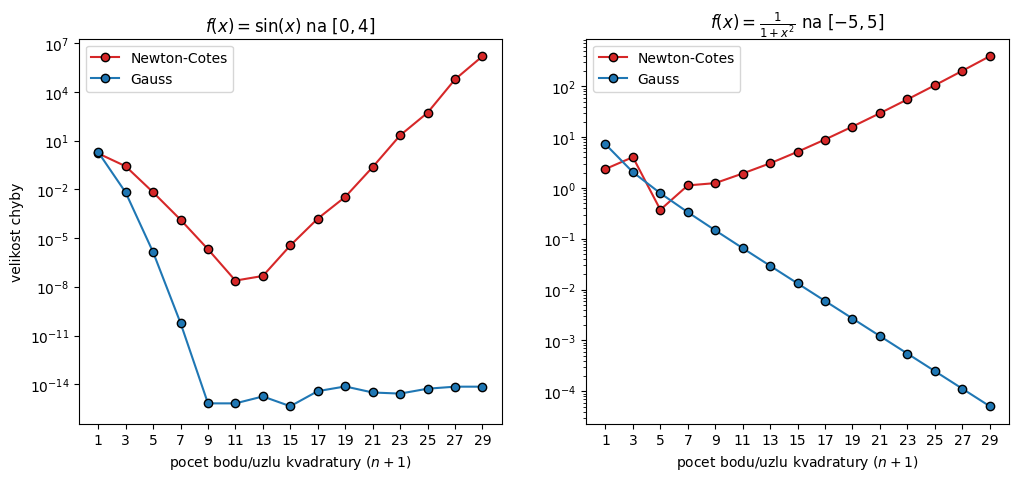

In [ ]:
def f1(x):
  return
def f1_Primitive(x):
  return

def f2(x):
  return
def f2_Primitive(x):
  return

# inicializace
n_totry = np.arange(0,30,2);
chyba_NC_f1 = np.zeros(len(n_totry)); chyba_G_f1 = np.zeros(len(n_totry));
chyba_NC_f2 = np.zeros(len(n_totry)); chyba_G_f2 = np.zeros(len(n_totry));

# vypocet
for ... :

  ### f1
  chyba_NC_f1[] =
  chyba_G_f1[] =

  ### f2
  chyba_NC_f2[] =
  chyba_G_f2[] =


############################################# Vykreslovani
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(n_totry+1, chyba_NC_f1, "-o", color='tab:red', label='Newton-Cotes', markeredgecolor="k")
plt.semilogy(n_totry+1, chyba_G_f1, "-o", color='tab:blue', label='Gauss', markeredgecolor="k")
plt.xlabel("pocet bodu/uzlu kvadratury ($n+1$)");
plt.ylabel("velikost chyby")
plt.title(r'$f(x) = \sin(x)$ na $[0,4]$')
plt.xticks(n_totry+1); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(n_totry+1, chyba_NC_f2, "-o", color='tab:red', label='Newton-Cotes', markeredgecolor="k")
plt.semilogy(n_totry+1, chyba_G_f2, "-o", color='tab:blue', label='Gauss', markeredgecolor="k")
plt.xlabel("pocet bodu/uzlu kvadratury ($n+1$)");
plt.title(r'$f(x) = \frac{1}{1+x^2}$ na $[-5,5]$')
plt.xticks(n_totry+1); plt.legend(); plt.show()
############################################# Vykreslovani

### ZÚ - symetrie Lagrangeových bazických polynomů

---
**Tužka & papír** :
- Ukažte, že na intervalu $(-1,1)$ pro rovnoměrné kvadraturní body $x_0,\dotsc,x_n$ platí $\ell_i(-x) = \ell_{n-i}(x)$

- <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>
  Odvoďte si vztah mezi $x_i$ a $x_{n-i}$.
  </details>

- Ukažte, že na intervalu $(-1,1)$ pro rovnoměrné kvadraturní body $x_0,\dotsc,x_n$ platí $w_i = w_{n-i}$.
- Ukažte, že na libovolném intervalu $(a,b)$ pro rovnoměrné kvadraturní body $x_0,\dotsc,x_n$ platí $w_i = w_{n-i}$.
- Ukažte, že na libovolném intervalu $(a,b)$ pro rovnoměrné kvadraturní body $x_0,\dotsc,x_n$ platí $w_0 = b-a - \sum_{i=1}^{n} w_{i}$

- <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>
  Spočtěte $\int_a^b 1 \mathrm{d}x$ pomocí kvadratury i pomocí klasického integrálního kalkulu, co pro výsledkz platí?
  </details>

---



## Část B: Metody založené na po částech polynomiální interpolaci (aka kompozitní kvadratury)


Idea je možná už jasná - interval $[a,b] \subset \mathbb{R}$ rozsekáme na $N$ podintervalů $(c_k,c_{k+1}), k=0,\dotsc N-1$ a použijeme polynomiální kvadraturu na každém intervalu zvlášť. To odpovídá aproximaci funkce $f(x)$ po částech polynomiální funkcí $r_f(x)$

$$
r_f(x) = p_f^{(k)}(x)  \quad \mathrm{pro} \quad x \in (c_k,c_{k+1}), \\
\mathrm{kde} \quad \equiv \sum_{i=0}^{n} \ell_i^{(k)}(x) f(x_i^{(k)}).
$$

Následně aproximujeme náš integrál jako

$$
\int_{a}^{b} f(x) \mathrm{d}x \, \approx \, \int_{a}^{b} r_f(x) \mathrm{d}x = \sum\limits_{k=0}^{N-1} \int_{c_k}^{c_{k+1}} p_f^{(k)}(x) \mathrm{d}x = \sum\limits_{k=0}^{N-1} \sum_{i=0}^{n} w_i^{(k)} f(x_i^{(k)}).
$$

Aby poslední rovnost výše platila, tak musíme kvadraturu volit tak, aby integrály $\int_{c_k}^{c_{k+1}} p_f^{(k)}(x) \mathrm{d}x$ už byly spočteny přesně. Jinými slovy, volíme kvadraturu o $n+1$ bodech/uzlech, kde $n+1$ je stupeň lokálních polynomů $p_f^{(k)}(x)$.

V takovém případě se aproximace dopouštíme opět pouze vy smyslu interpolace a integrály interpoločních po-částech-polynomů $r_f(x)$ už jsou spočteny přesně.

### Úloha B1 - implementace

---
**Kódění** :
- Naimplementujte funkci `KompozitniKvadratura()` podle anotace níže.
- Doplňte kód níže tak, aby vykresloval závislost chyby kompozitní kvadratury $\int_{a}^{b} r_f(x) \mathrm{d}x$ oproti přesnému integrálu $\int_{a}^{b} f(x)\mathrm{d}x$ v závislosti na počtu vyhodnocení funkce $f$ při aproximaci integrálu.
----

In [ ]:
def KompozitniKvadratura(f, a,b,n,N,TypKvadratury="Newton-Cotes"):
  '''
  Pro danou funkci "f" a krajni body intervalu "[a,b]", rad "n", pocet deleni "N" a "TypKvadratury" aproximujeme integral funkce "f" na intervalu [a,b] pomoci daneho typu kompozitni kvadratury.

  Input
  -------
  f :   python funkce (callable). Funkce vyhodnocujici hodnoty "f : R -> R",
        syntax "f( np.array([x1,...,xn]) )" je akceptovan a vraci output "np.array([f(x1),...,f(xn)])"
  a :   np.float64. Levy okraj integracniho intervalu
  b :   np.float64. Pravy okraj integracniho intervalu
  n :   np.int32. pocet interpolacnich bodu je "n+1" (drzime se notace, ze kvadratura je suma od "0" do "n")
  N :   np.int32. pocet delelni intervalu [a,b] na podintervaly [c0,c1], ..., [cN-1,cN]
  TypKvadratury :  string. Urcuje typ kcadratury na [-1,1], ze ktere odvodime kvadraturu na [a,b]
                    - preddefinovana moynost je "Newton-Cotes"
                    - musi take zvladnout "Gauss-Legendre"

  Output
  -------
  AproxIntegr :  np.float64. aproximace integralu int_a^b f(x) dx

  Poznamka
  -------
  Pripad pokud ke generovani c0,...cN pouzivame np.linspace(), pak "N=1" bude nejspise nutne vyresit separatne.
  '''
  return AproxIntegr

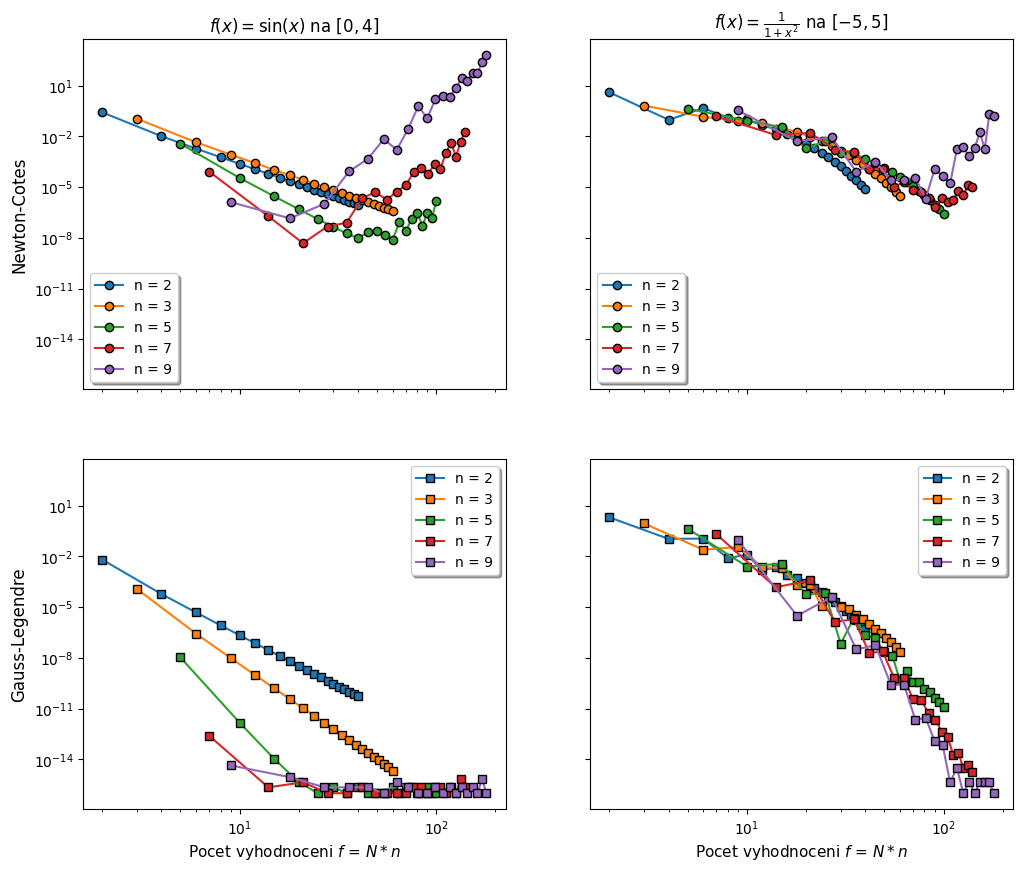

In [ ]:
def f1(x):
  return np.sin(x)
def f1_Primitive(x):
  return -np.cos(x)

def f2(x):
  return 1 / (1 + x**2)
def f2_Primitive(x):
  return np.arctan(x)

# inicializace
n_totry = np.array([2,3,5,7,9]);
N_totry = np.arange(1,21,1);
IntegrChyba_NC_f1 = np.zeros( (len(n_totry),len(N_totry)) ); IntegrChyba_G_f1 = np.zeros_like(IntegrChyba_NC_f1)
IntegrChyba_NC_f2 = np.zeros_like(IntegrChyba_NC_f1); IntegrChyba_G_f2 = np.zeros_like(IntegrChyba_NC_f1)


for ind_n in range():

  for ind_N in range():

    ### f1
    IntegrChyba_NC_f1[ind_n,ind_N] =
    IntegrChyba_G_f1[ind_n,ind_N] =

    ### f2
    IntegrChyba_NC_f2[ind_n,ind_N] =
    IntegrChyba_G_f2[ind_n,ind_N] =


########################################## Vykreslovani
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,10))
for ind_n in range(0,len(n_totry)):
  n = n_totry[ind_n];
  ax1.loglog(N_totry * n, IntegrChyba_NC_f1[ind_n,:], "-o", label="chyba pro $n$ = {}".format(n), markeredgecolor="k")
  ax2.loglog(N_totry * n, IntegrChyba_NC_f2[ind_n,:], "-o", label="chyba pro $n$ = {}".format(n), markeredgecolor="k")
  ax3.loglog(N_totry * n, IntegrChyba_G_f1[ind_n,:], "-s", label="chyba pro $n$ = {}".format(n), markeredgecolor="k")
  ax4.loglog(N_totry * n, IntegrChyba_G_f2[ind_n,:], "-s", label="chyba pro $n$ = {}".format(n), markeredgecolor="k")

ax1.set_ylabel("Newton-Cotes",fontsize=12); ax1.set_title(r'$f(x) = \sin(x)$ na $[0,4]$',fontsize=12)
ax2.set_title(r'$f(x) = \frac{1}{1+x^2}$ na $[-5,5]$',fontsize=12)
ax3.set_ylabel("Gauss-Legendre",fontsize=12); ax3.set_xlabel("Pocet vyhodnoceni $f$ = $N * n$",fontsize=11);
ax4.set_xlabel("Pocet vyhodnoceni $f$ = $N * n$",fontsize=11);
ax1.legend(fancybox=True, shadow=True, ncol=1); ax2.legend(fancybox=True, shadow=True, ncol=1)
ax3.legend(fancybox=True, shadow=True, ncol=1); ax4.legend(fancybox=True, shadow=True, ncol=1)
plt.show()
########################################## Vykreslovani

### Úloha B2 - porovnání

---
**Tužka a papír** :
- Vysvětlete charakteristické rysy vykreslených grafů.
- Jaký lze udělat závěr pro kompozitní kvadratury pokud jde o volbu vnitřního kvadraturního pravidla?
- Jaký lze udělat závěr pro numerickou integraci pokud jde o volbu "kompozitní vs. přímá"? Je jedna možnost vždy lepší než druhá?
----

### Úloha B3 - jde to stihnout?

Na příkladech výše jsme viděli, že numerické kvadratury konvergují často lineárně nebo dokonce superlineárně vzhledem k počtu vyhodnocení integrované funkce $f$. Jsou robustní pro velkou třídu funkcí a pro výpočet těchto kvadratur existují stabilní algoritmy. V praxi jsme ovšem konfrontováni **s vysoko-dimenzionálními integrály**, tj. s výpočtem integrálů typu

$$
\int_{a_1}^{b_1} \cdots \int_{a_d}^{b_d} f(x_1,\dotsc, x_d) \; \mathrm{d}x_1\dotsc \mathrm{d}x_d,
$$

pro $d \gtrapprox 50$.

Přímé zobecnění kvadratur výše pro $d>1$ v jistém kroku "vždy" obsahuje "kvadratury na intervalech", nebo-li  použití známých kvadraturních pravidel na aproximaci jedno-dimenzionálních integrálů $\int_{a_1}^{b_1} \dotsc \mathrm{d}x_1$, $\int_{a_2}^{b_2} \dotsc \mathrm{d}x_2$ atd.

---
**Tužka a papír** :
- Předpokládejme, že $d=50$ a že na každý jedno-dimenzionální integrál použijeme 5-bodovou Gaussovu kvadraturu (dejme tomu, že toto by bylo dostatečná přesné). Jaký počet vyhodnocení funkce $f$ bychom potřebovali?

- V současné době (srpen 2025) je nejvýkonějším superpočítač na světě [El Capitan](https://en.wikipedia.org/wiki/El_Capitan_(supercomputer)) schopen řádově $10^{18}$ floating-point operací za vtěřinu. Předpokládejme, že vyhodnocení funkce $f$ lze vykonat ze jednu floating-point operaci (zjevně hodně optimistické). Jak dlouho by trvalo, než bychom získali potřebný počet vyhodnocení funkce $f$?
  - Kolik vteřin příbližně uběhlo od počátku vesmíru ([wiki](https://en.wikipedia.org/wiki/Age_of_the_universe))? Porovnejte s potřebným časem.
---

Zjevně tedy potřebujeme efektivnější přístup a asi nejběžnějšími metodami jsou metody typu [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration), které se bohužel do kurzu nevešly, ale můžete si je vyzkoušet na podobném googlesheetu na mých [webovkách](https://michaloutrata.com/#CoursePage_UNM).

## [Kvíz](https://forms.gle/8FQwpsmKXYJ9EKfb9)